In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

import matplotlib.pyplot as plt

In [3]:
from app.utils import ImageWrapper
from app.custom import RemoveBusBars, Orient
from app.transforms import FFT, IFFT, CreateOnesMask, PCA
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure

In [4]:
## Utility function:
def variance_plot(explained_var_ratio, n_components, pct = True):
    """Helper function to plot the captured variance"""
    
    # Define X axis intervals:
    x=np.arange(1, n_components + 1)
    # Cumulative variance:
    if pct:
        y1 = explained_var_ratio * 100
    else:
        y1 = explained_var_ratio
    y2 = np.cumsum(y1)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax1.bar(x, y1, color = 'g')
    ax2.plot(x, y2, color = 'b')
    
    ax1.set_xlabel('Principal Component Number')
    ax1.set_xticks(x)
    
    if pct:
        ax1.set_ylabel('Explained Variance %', color='g')
        ax2.set_ylabel('Cumlative Explained Variance %', color='b')
    else:
        ax1.set_ylabel('Explained Variance', color='g')
        ax2.set_ylabel('Cumlative Explained Variance', color='b')
        
def plot_gallery(images, h, w, n_row=4, n_col=5):
    """Helper function to plot a gallery of portraits
       Adapted from https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap='Greys_r')
        plt.title(f'Eigenface_{i+1}', size=12)
        plt.xticks(())
        plt.yticks(())

In [5]:
# Seed used in show to show the same images when num_images option is set
seed = 1234

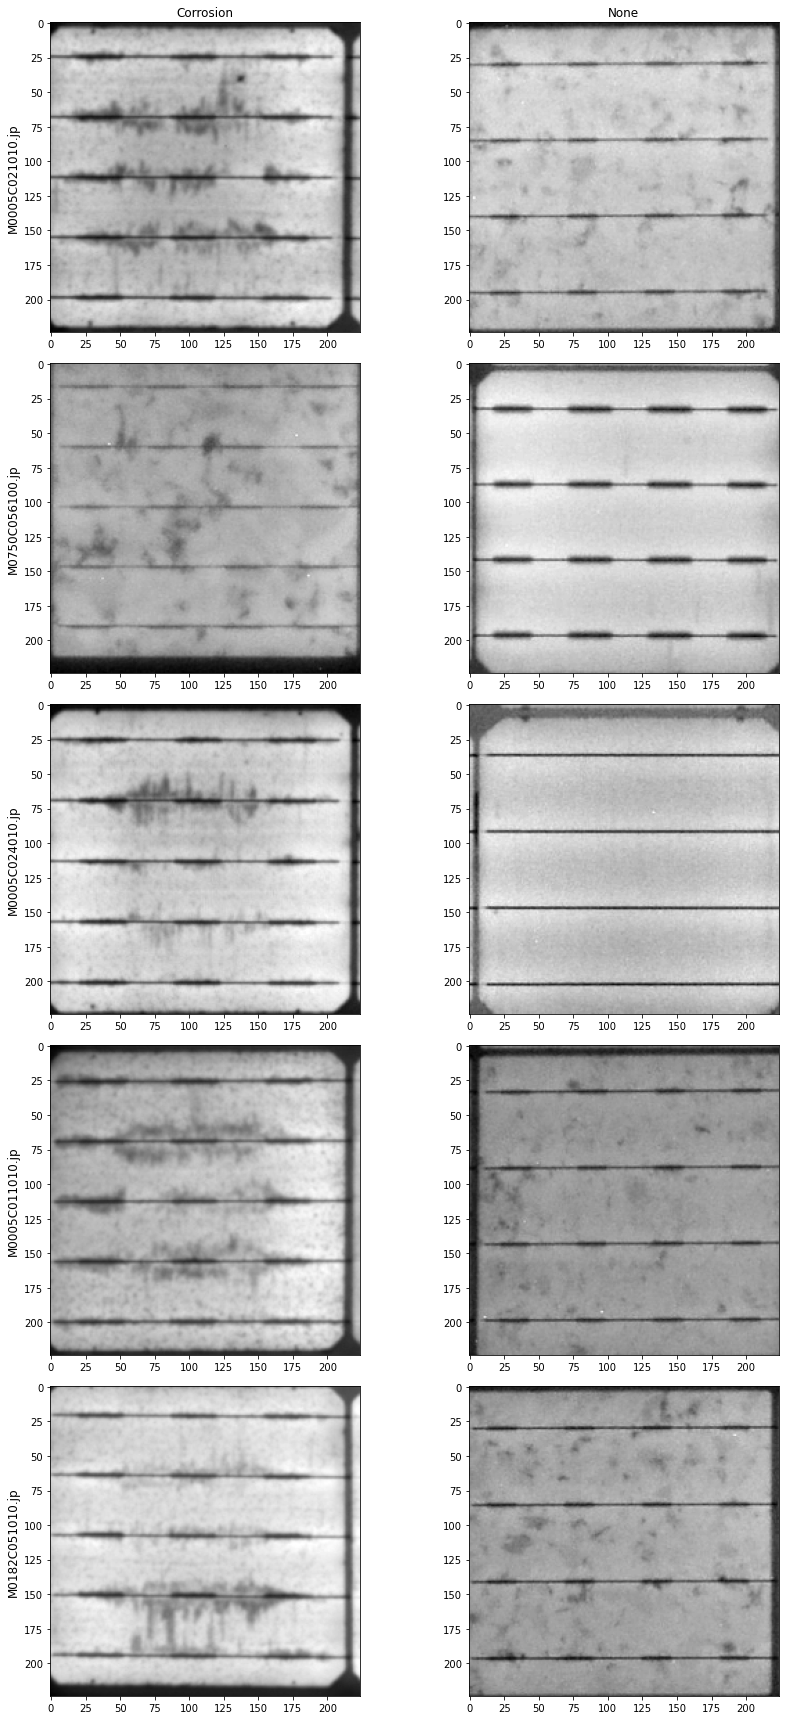

In [6]:
# Load 100 examples and name the category for it. Category is like a title for images
n_samples = 500
defect = (DefectViewer() << (ImageLoader(defect_class='Corrosion') << n_samples))
defect.category = 'Corrosion'
clean = (DefectViewer() << (ImageLoader(defect_class='None') << n_samples))
clean.category = 'None'

# View both the defect and the clean class
# I am using a tuple in this case as defect and clean are ImageWrapper objects
# Show random 5 out of the 10 images. Using the seed will ensure the same 5 are shown everytime
_ = Show(num_images=5, seed=seed) << (defect, clean)

## What does the mean Clean and Corrosion Image look like?

In [7]:
# Calculate the average of all images within each category. 
average_clean = np.mean(clean.images, axis=0)
average_corrosion = np.mean(defect.images, axis=0)

Average Clean Cell


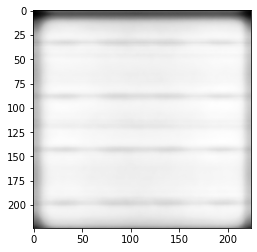

In [8]:
print('Average Clean Cell')
plt.imshow(average_clean, cmap='Greys_r')

Average Corroded Image


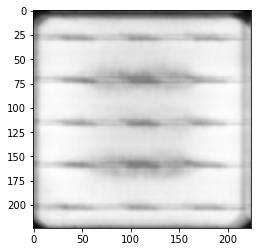

In [9]:
print('Average Corroded Image')
plt.imshow(average_corrosion, cmap='Greys_r')

## PCA on all images
### Analysis of principal components and variance 

20 principal components explain 93.89 % of the total variance


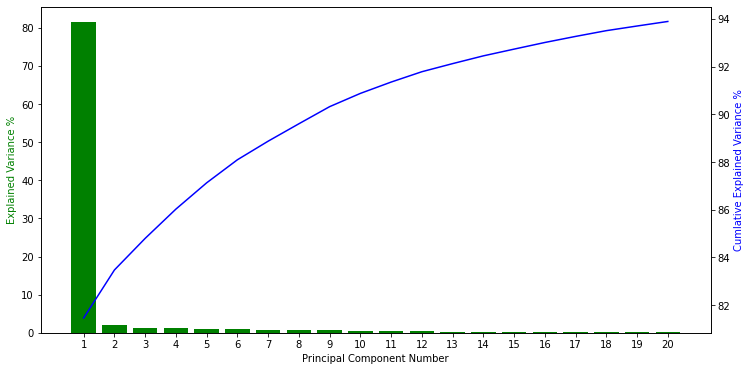

In [10]:
# Instantiate class
n =20
PCA_class_clean = PCA(transpose=True, n_components=n, whiten=True)

# Claculate the transform on the images
PCA_class_clean << clean

# Total explained Variance
exp_var = PCA_class_clean.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
variance_plot(exp_var, n)

20 principal components explain 98.77 % of the total variance


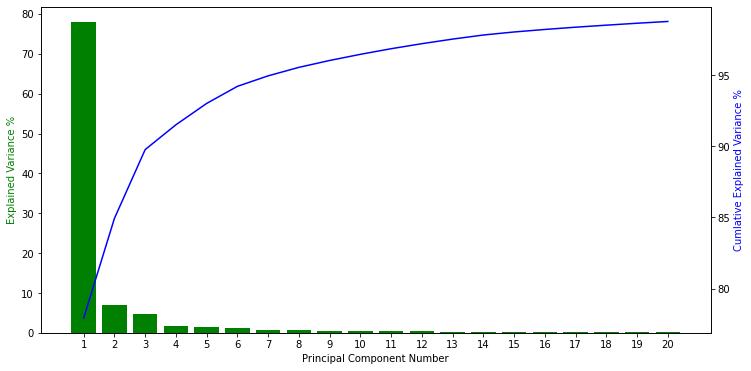

In [11]:
# Instantiate class
n = 20
PCA_class_defect = PCA(transpose=True, n_components=n, whiten=True)

# Claculate the transform on the images
PCA_class_defect << defect

# Total explained Variance
exp_var = PCA_class_defect.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
variance_plot(exp_var, n)

### Let's view the Eigenfaces of each

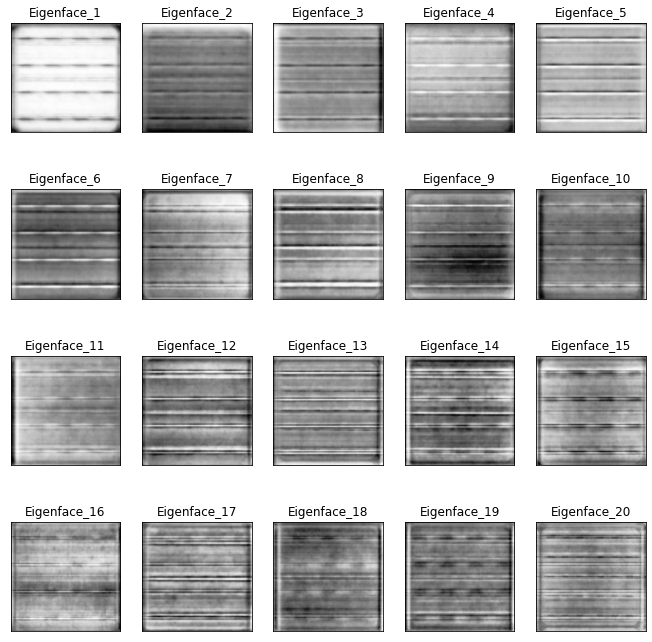

In [12]:
## Clean images
plot_gallery(PCA_class_clean.eigenfaces[0], 224, 224)

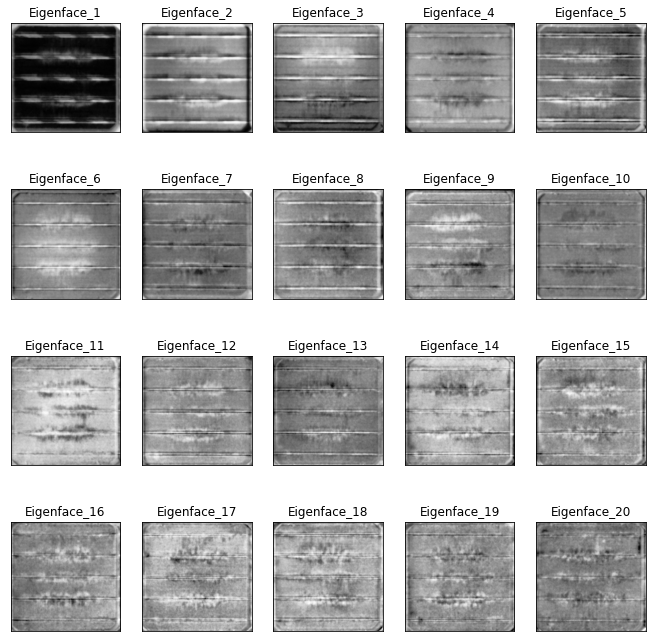

In [13]:
## Defected images
plot_gallery(PCA_class_defect.eigenfaces[0], 224, 224)

## Apply PCA transforms on 500 images

#### Clean images, PCA on 500 stacked images to 2 components

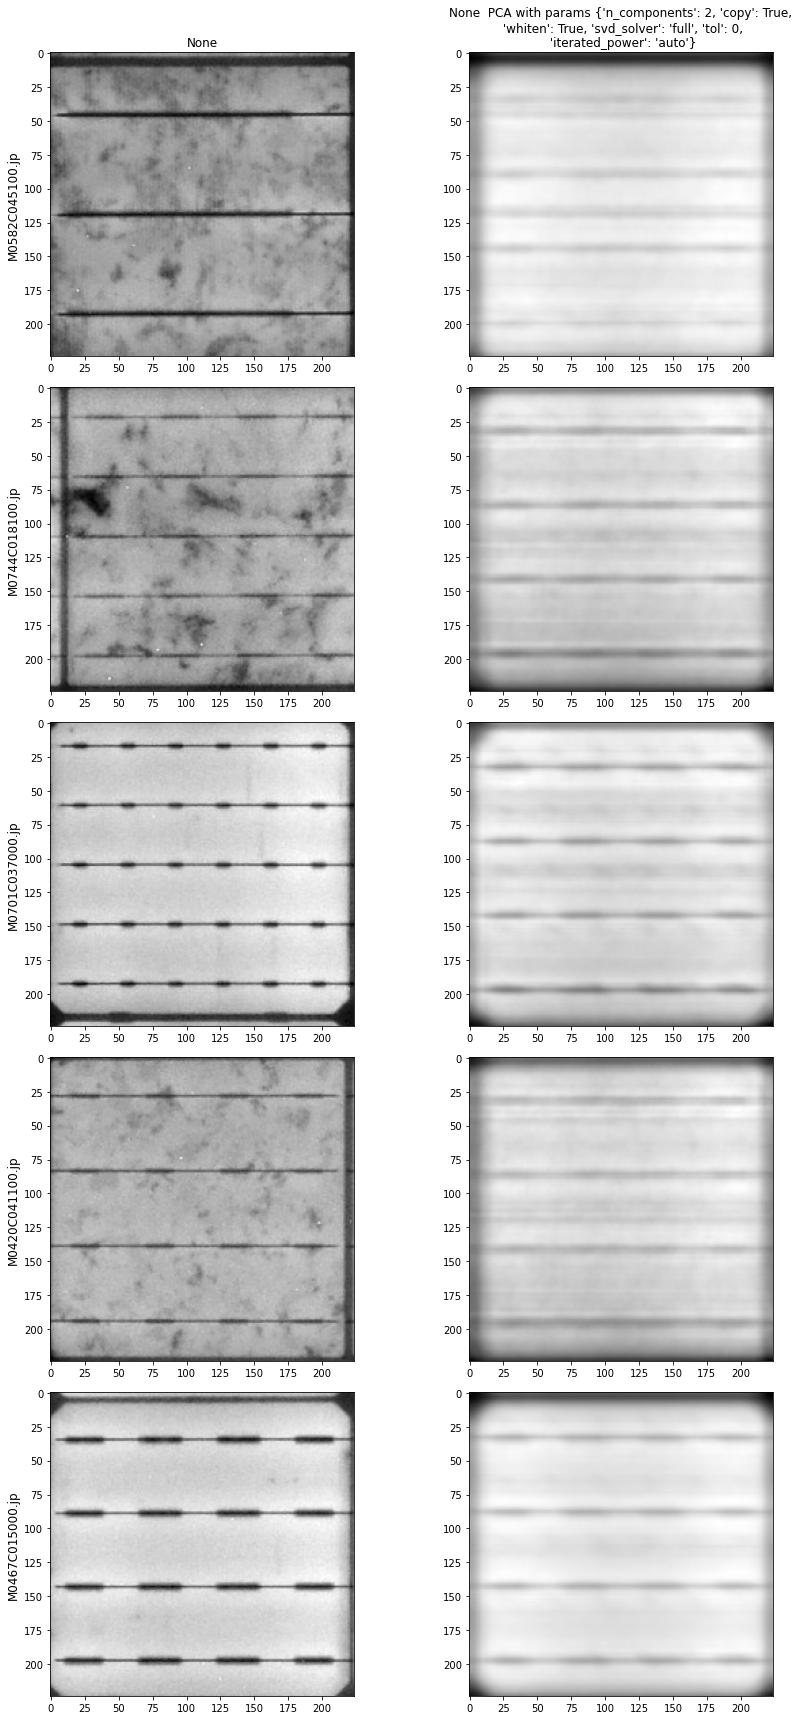

In [20]:
_ = Show(num_images=5, seed=40) << (PCA(transpose=True, n_components = 2, whiten=True) << (clean))

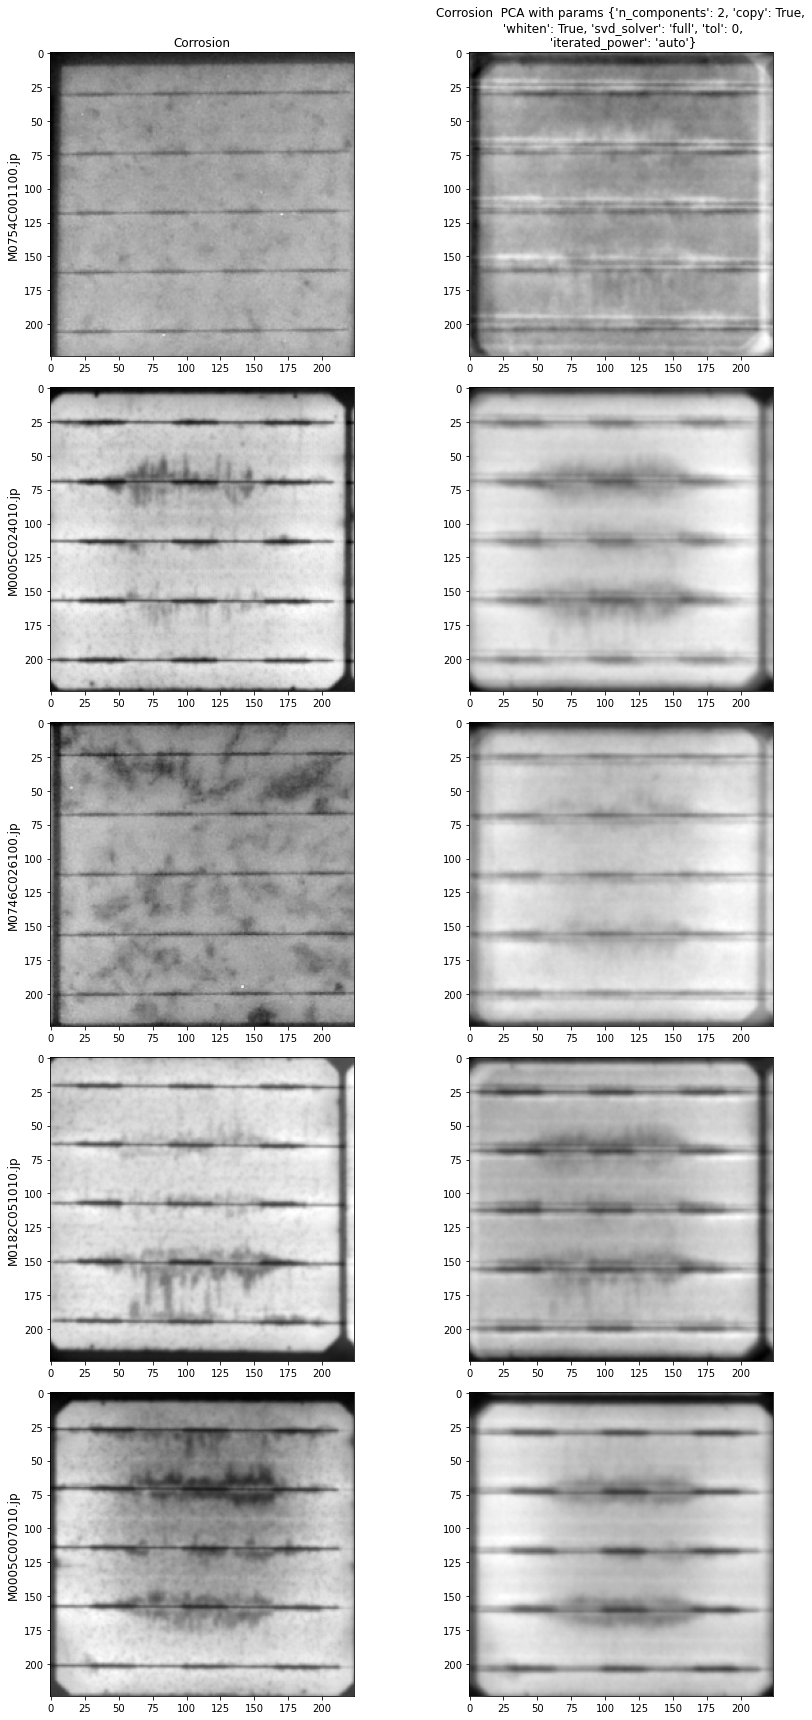

In [21]:
#### Clean images, PCA on 500 stacked images to 6 components
_ = Show(num_images=5, seed=40) << (PCA(transpose=True, n_components = 2, whiten = True) << (defect))

### PCA for segmentation

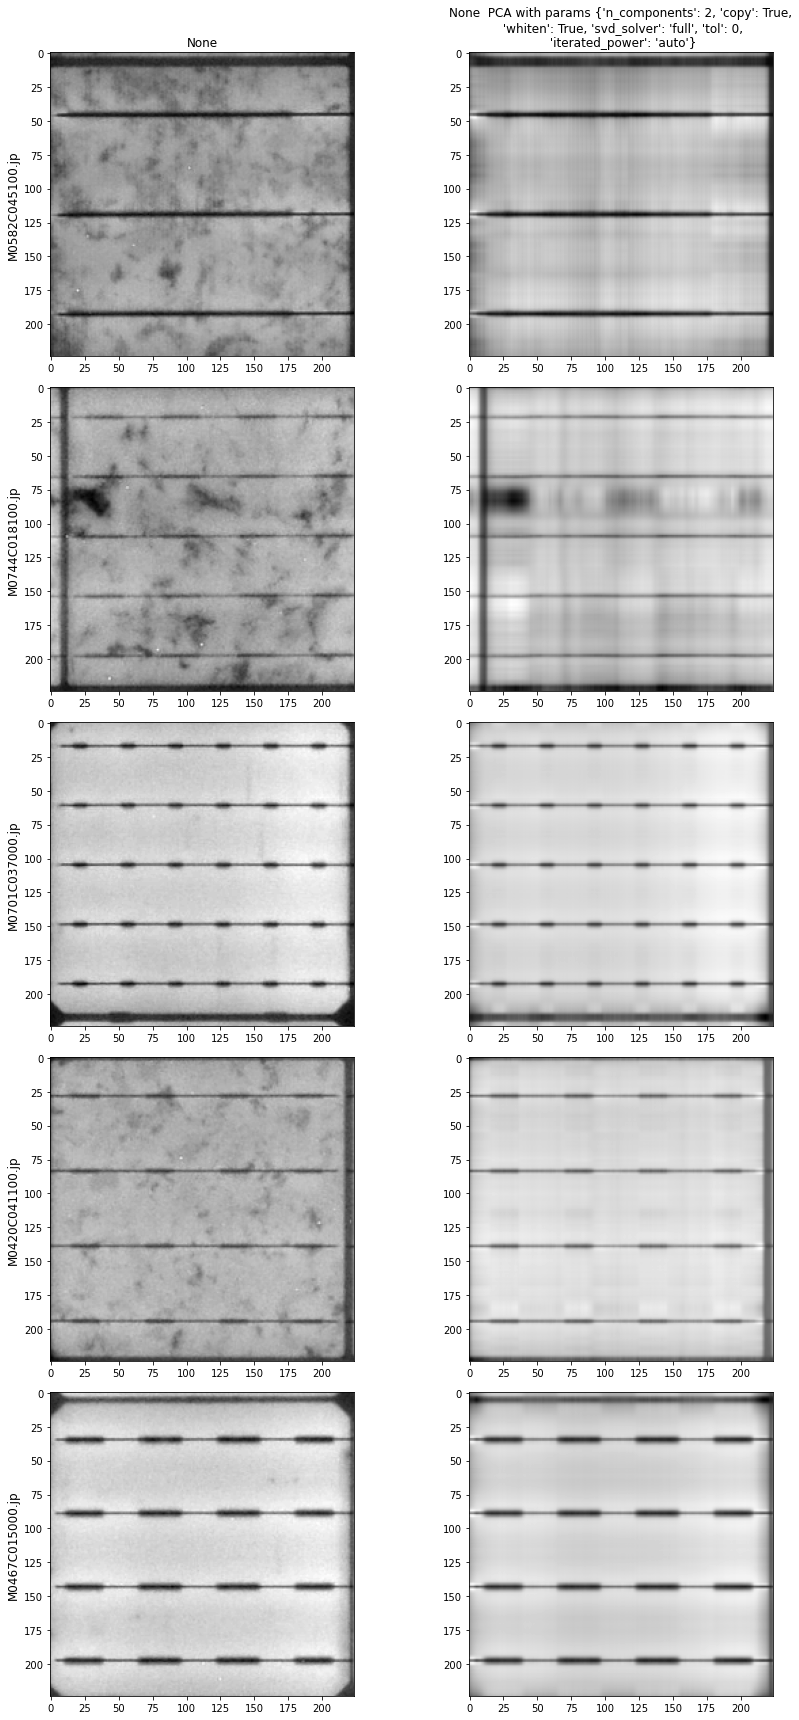

In [26]:
_ = Show(num_images=5, seed=40) << (PCA(transpose=False, n_components = 2, whiten=True) << (clean))

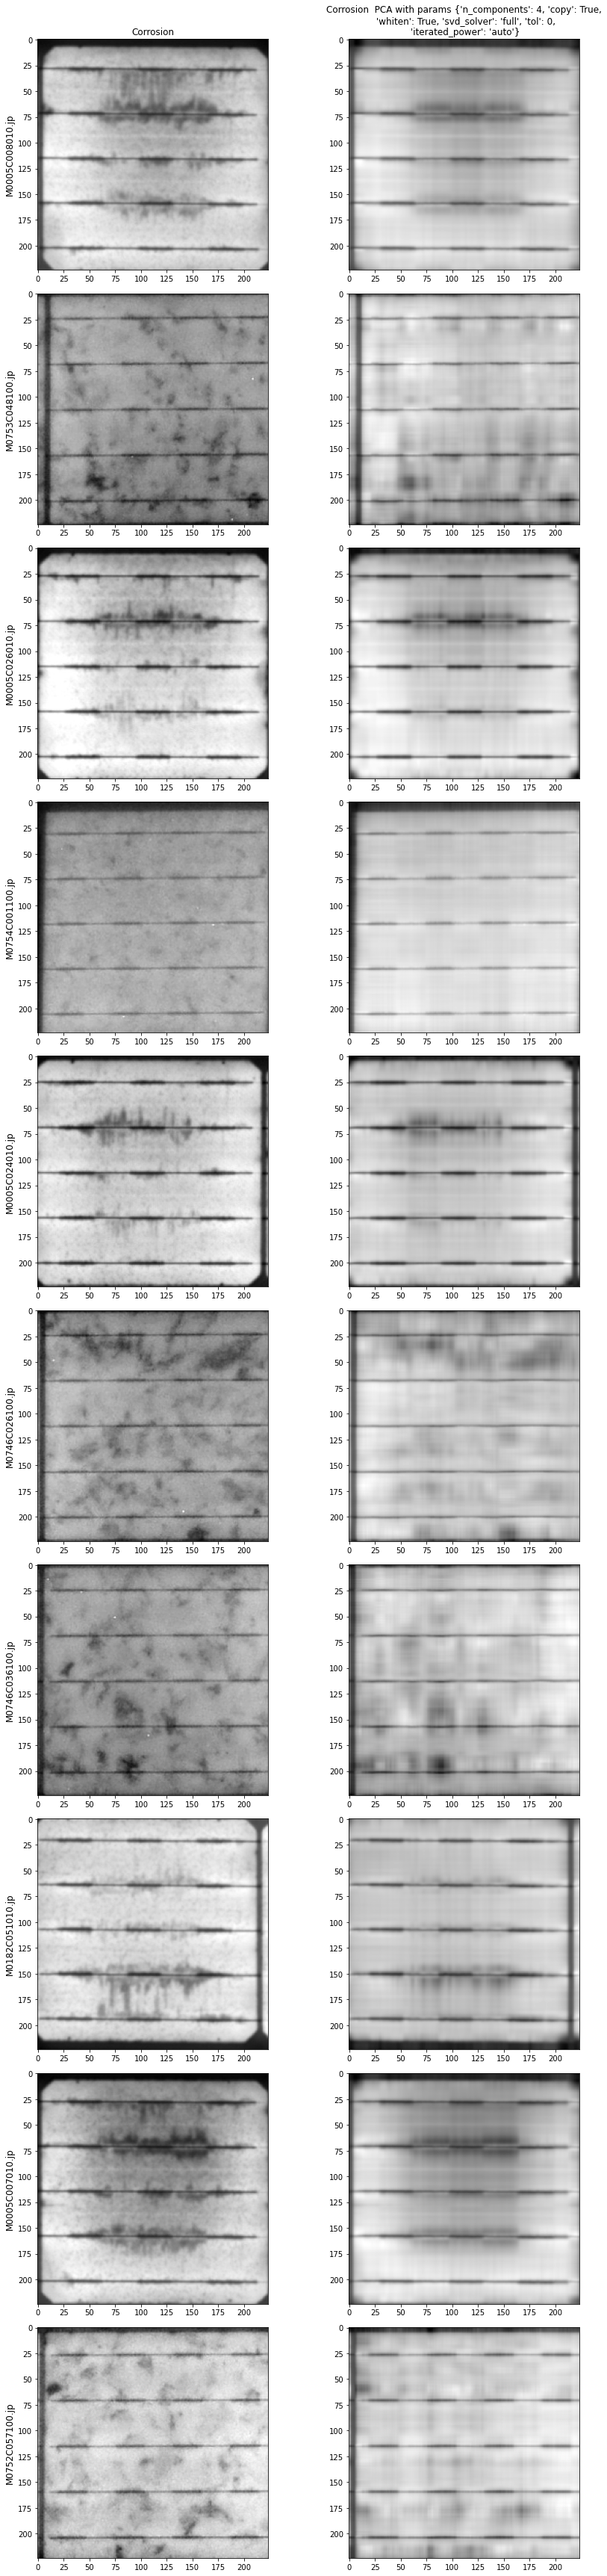

In [28]:
_ = Show(num_images=10, seed=40) << (PCA(transpose=False, n_components = 4, whiten=True) << (defect))